<a href="https://colab.research.google.com/github/kaori-kanno/heart_recon/blob/main/recon_test_parteII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import userdata
# token = userdata.get('cosas-tabita')

# !git clone 'https://{token}@github.com/kaori-kanno/NF-cMRI-tabita.git'
# %cd NF-cMRI-tabita/

fatal: destination path 'NF-cMRI-tabita' already exists and is not an empty directory.
/content/NF-cMRI-tabita


In [ ]:
# !pip install -e . # instala como librería y e permite editar

Obtaining file:///content/NF-cMRI-tabita
  Preparing metadata (setup.py) ... done
  Attempting uninstall: inrmri
    Found existing installation: inrmri 0.3.0
    Uninstalling inrmri-0.3.0:
      Successfully uninstalled inrmri-0.3.0
  Running setup.py develop for inrmri


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
# import inrmri

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive') # directorio de todas las carpetas
os.chdir("/content/drive/MyDrive/joint_recon/Pig_2")
!ls

Mounted at /content/drive
diffusion_directions.txt  image_real.mat   kspace_real.mat
image_imag.mat		  kspace_imag.mat


In [ ]:
# ir = loadmat('Pig_2/image_real.mat')['image_real']
# im = loadmat('Pig_2/image_imag.mat')['image_imag']

ir_data = loadmat('/content/drive/MyDrive/joint_recon/Pig_2/image_real.mat')
im_data = loadmat('/content/drive/MyDrive/joint_recon/Pig_2/image_imag.mat')

In [ ]:
real = ir_data['image_real']
imag = im_data['image_imag']

In [ ]:
image = real + 1j*imag # combinamos la parte real e imaginaria para formar la imagen completa
image = image/np.max(np.abs(image)) # se normaliza la imagen por el valor máximo

In [ ]:
# recortamos un slice de todas las imágenes en el plano XY
slice = image[:,:,24,4,:]
slice = np.transpose(slice, (2,0,1))
# slice.shape

In [ ]:
M0 = image[:,:,22,0,0].copy() # imagen con b = 0 en corte 24
M0mask = np.abs(M0) > 0

In [ ]:
# aplicamos Fourier en las imágenes

k_space = np.fft.fft2(slice)
k_space.shape

(457, 38, 72)

In [ ]:
n_masks = 6 # se crean máscaras en el espacio k para simular un muestreo de las imágenes
masks = []
max_lines = 11 # máximo de líneas que conservaremos en cada máscara.
bandwith = 3 # bandas a conservar al centro y a los extremos (información muy relevante en la imagen)
for i in range(n_masks):
    mask = np.zeros(k_space.shape[1:]).astype(bool) # creamos la máscara
    mask[np.arange(i,k_space.shape[1],6)] = 1 # en la máscara creada, marca como 1 (o True) cada 6 pasos, partiendo en i.


    # se conservan la banda superior e inferior como 1 o True:
    mask[-bandwith:] = 1
    mask[:bandwith] = 1

    if mask[:,0].sum() > max_lines: # si se excede el número de líneas permitidas
        idxs = np.where(mask[:,0]>0)[0] # se obtienen los índices de las filas
        order = np.argsort(np.abs(idxs - mask.shape[0]//2))
        idx = idxs[order][:(mask[:,0].sum() - max_lines)] # se ordenan las filas
        print(idx, mask[idxs[0],0])
        mask[idx,:] = 0 # se hacen 0 o False las líneas más alejadas del centro.

    masks.append(mask)
    print(mask[:,0].sum()) # imprimimos la suma de los valores que están en la fila 0 (deberían sumar max_lines)





11
11
11
[21] True
11
[16] True
11
11


## neural network

In [ ]:
import os

os.environ["ENABLE_PJRT_COMPATIBILITY"] = "1"

import jax.numpy as np
from jax import random, grad, jit, vmap
import jax
from jax.scipy.optimize import minimize
import numpy as onp
from jax.experimental.ode import odeint
from jax.example_libraries import optimizers
from functools import partial
from matplotlib import pyplot as plt
from jax.nn import relu
key = random.PRNGKey(0)

In [ ]:
def init_params(layers, key):
  Ws = [] # lista de matrices de pesos
  bs = [] # lista de vectores de sesgos
  for i in range(len(layers) - 1):
    std_glorot = np.sqrt(2/(layers[i] + layers[i + 1])) # mediante glorot se definen los pesos
    key, subkey = random.split(key) # mantiene aleatoriedad controlada, mediante jax se asignan los pesos random
    Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    bs.append(np.zeros(layers[i + 1])) # se crean los pesos en 0
  return (Ws, bs)

@jit
def forward_pass(H, params):
  """
  Esta es un MLP
  """
  Ws = params[0]
  bs = params[1]
  N_layers = len(Ws)
  for i in range(N_layers - 1):
    H = np.matmul(H, Ws[i]) + bs[i] # multiplicación de los pesos + bias
    H = np.tanh(H) # función de activación no lineal aplicada en la red
  Y = np.matmul(H, Ws[-1]) + bs[-1] # capa final sin función de activación
  return Y

def init_params_icnn(layers, key):
  Wz = [] # pesos aplicados a Z (capas intermedias)
  Wy = [] # pesos aplicados a Y (input original)
  bs = [] # bias para cada capa oculta

  std_glorot = np.sqrt(2/(layers[i] + layers[i + 1]))
  key, subkey = random.split(key)
  Wy.append(random.normal(subkey, (layers[0], layers[1]))*std_glorot)

  for i in range(1,len(layers) - 1):
    std_glorot = np.sqrt(2/(layers[i] + layers[i + 1]))
    key, subkey = random.split(key)
    Wz.append(-3 + random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot) #Wz recibe pesos inicializados con ruido negativo (-3 + random...) para garantizar valores pequeños
    Wy.append(random.normal(subkey, (layers[0], layers[i + 1]))*std_glorot) # se conecta la capa de entrada, 0, con las capas ocultas
    bs.append(np.zeros(layers[i + 1]))
  return (Wz, Wy, bs)

@jit
def icnn_forwardpass(Y, params): # se recorren hacia adelante las capas
  """
  Esta es un ICNN
  """
  Wz, Wy, bs = params
  N_layers = len(Wy)
  Z = relu(np.matmul(Y, Wy[0]) + bs[0])  # esta es la capa de entrada Y
  for i in range(1, N_layers - 1): # aquí se recorren las capas intermedias
    Z = np.matmul(Z, np.exp(Wz[i-1])) + np.matmul(Y, Wy[i]) + bs[i]
    Z = relu(Z) # se da una función de activación
  Z = np.matmul(Z, np.exp(Wz[-1])) + np.matmul(Y, Wy[-1]) + bs[-1]  # última capa, sin activación no lineal
  return Z


@jit
def ff_forwardpass_B(X, params, B):
  """
  Aplicar Fourier a la data de entrada x.
  B es una matriz
  """
  angles = 2*np.pi*vmap(np.dot, in_axes = (None, 0))(B, X) # calcula el producto punto entre cada fila de X y B, B @ X.T
  # estos son los ángulos de los features
  gamma = np.concatenate((np.sin(angles), np.cos(angles)), axis = 1) # Fourier Feature Mapping, un truco para mapear tus datos a un espacio más rico.
  return forward_pass(gamma, params)  #  se pasa gamma por el MLP forward_pass

@partial(jit, static_argnums=(0,))
def step(loss, i, opt_state, X_batch, Y_batch):
    params = get_params(opt_state)  # extrae los parámetros
    g = grad(loss)(params, X_batch, Y_batch)  # calcula el gradiente de la función de pérdida respecto a los parámetros
    return opt_update(i, g, opt_state) # actualiza los parámetros con un tamaño adecuado

def train(loss, X, Y, opt_state, key, nIter = 10000, batch_size = 10):
    """
    Aquí entrenamos el modelo para varias iteraciones con batches de data X e Y que se crean aquí
    """
    train_loss = []
    val_loss = []
    for it in range(nIter):
        key, subkey = random.split(key)
        # idx_batch = random.choice(subkey, X.shape[0], shape = (batch_size,), replace = False) # toma un batch aleatorio
        opt_state = step(loss, it, opt_state, X, Y) # actualiza los parámetros con step
       # opt_state = step(loss, it, opt_state, X, Y)
        if it % 100 == 0:  # cada 100 iteraciones:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y) # train_loss_value = loss(params, X[idx_batch], Y[idx_batch])
            train_loss.append(train_loss_value)  # mide la pérdida del batch
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return opt_state, train_loss, val_loss

def train_batch(loss, Xb, Yb, opt_state, key, nIter = 10000):
    train_loss = []
    val_loss = []
    it = 0
    while it < nIter: # itera en los batches
        for X, Y in zip(Xb, Yb): # Xb, Yb son listas de batches
          opt_state = step(loss, it, opt_state, X, Y)
          it += 1
          if it % 100 == 0:
              params = get_params(opt_state)
              train_loss_value = loss(params, X, Y)
              train_loss.append(train_loss_value)
              to_print = "it %i, train loss = %e" % (it, train_loss_value)
              print(to_print)
    return get_params(opt_state), train_loss, val_loss

def create_batches(input, output, batch_size):
    """
    Divide los datos en mini-batches y los devuelve
    """
    # Ensure input and output have the same first dimension length
    assert input.shape[0] == output.shape[0], "Input and output must have the same number of samples"

    num_samples = input.shape[0]  # número de muestras totales

    # Shuffle indices
    shuffled_indices = random.permutation(jax.random.PRNGKey(0), num_samples) # Crea un orden aleatorio de los índices (0 a num_samples-1)
    input_shuffled = input[shuffled_indices]
    output_shuffled = output[shuffled_indices] # reordena las muestras del output

    # Split the data into batches
    # Devuelve listas con batches de X e Y, listas de tamaño num_batches.
    input_batches = np.array_split(input_shuffled, num_samples // batch_size)
    output_batches = np.array_split(output_shuffled, num_samples // batch_size)

    return input_batches, output_batches




In [ ]:
@jit
def cartesian_to_spherical(x):
    """
    Se toma un vector 3D y se convierte a esféricas
    """
    r = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2)
    theta = np.arccos(x[2] / r)  # polar angle
    phi = np.arctan2(x[1], x[0])    # azimuthal angle
    return r, theta, phi

In [ ]:
# cargamos las direcciones de gradiente de difusión, son 457

dirs = onp.genfromtxt('diffusion_directions.txt', delimiter=';')

R, Theta, Phi= vmap(cartesian_to_spherical)(dirs) # vmap opera sobre un batch o conjunto de datos la operación dada

As = np.cos(Theta) # proyección en z de las direcciones
Bs = np.cos(Phi) # proyección en el plano XY



Acabamos de procesar direcciones existentes, podemos ahora mapear direcciones ideales:

In [ ]:
import mpl_toolkits.mplot3d

num_pts = 24
b_value = 6500
indices = np.arange(0, num_pts, dtype=float) + 0.5  # entrega valores igualmente espaciados en el rango (0, num_pts)
# sumamos 0.5 para que no sean los puntos de los extremos o los polos de la esfera.

phi = np.arccos(1 - 2*indices/num_pts) # esfera de Fibonacci
theta = np.pi * (1 + 5**0.5) * indices # esfera de Fibonacci, espiral con proporción áurea

# convertimos de esféricas a cartesianas con r = 1
# fórmula de fibonachi para una esfera donde los puntos están equidistantes repartidos.
x, y, z = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi)


# solo necesitamos mapear en una semi-esfera por simetría:
x_half = x[np.where(z >=0)]
y_half = y[np.where(z >=0)]
z_half = z[np.where(z >=0)]
b_value = np.repeat(b_value,x_half.shape[0])  # añadimos b al arreglo



directions = np.array([x_half,z_half,y_half]).transpose() # vector de dirección en 3d, (x, z, y)

Array([0.99878776, 0.997787  , 0.99924225, 0.99934345, 0.99963474,
       0.99877995, 0.99890304, 0.99883866, 0.99909306, 0.9991266 ,
       0.9997292 , 0.9977222 ], dtype=float32)

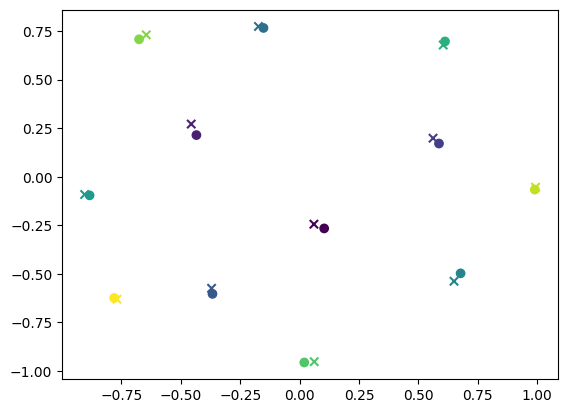

In [ ]:
# calculamos el producto punto entre cada dirección dir creada de direction con las otras direcciones dirs del scaner
ort = vmap(lambda dir, dirs: np.dot(dir,dirs), in_axes=(None, 0))(directions, dirs)


selected_dirs = np.argmax(ort, axis = 0) # el de mayor producto punto será la dirección más cercana
selected_dirs_vec = dirs[selected_dirs] # guardamos esas direcciones

plt.scatter(x_half, y_half, c = np.arange(x_half.shape[0]))
plt.scatter(selected_dirs_vec[:,0], selected_dirs_vec[:,2], c = np.arange(x_half.shape[0]), marker = 'x')
np.max(ort, axis = 0)

In [ ]:
# coordenadas del sistema:
Nx = k_space.shape[1] # tamaño de la transformada de fourier en x
Ny = k_space.shape[2] # tamaño de la transformada de fourier en y
x = np.arange(Nx)/(Nx - 1)*2 - 1 # normaliza las coordenadas Nx a valores entre -1 y 1
y = np.arange(Ny)/(Nx - 1)*2 - 1 # [0 a Ny-1]/(Ny-1) = [0 - 1]

X, Y = np.meshgrid(x, y, indexing = 'ij') # X, Y = np.meshgrid(x, y)
Xall = np.c_[X.flatten(), Y.flatten()] # aplana y concatena X con Y

# creamos las máscaras
masks = np.array(masks)
masks_rep = np.concatenate((masks, masks), axis = 0)  # se le agregan máscaras # masks_rep = np.concatenate((masks, masks[:3]), axis = 0)

input = []
output = []

for i,dir_idx in enumerate(selected_dirs): # son 9 puntos en selected_dirs
    input.append(np.c_[Xall, np.ones(Xall.shape[0])*As[dir_idx], np.ones(Xall.shape[0])*Bs[dir_idx]]) # (xs, ys, cos(th), cos(phi))
input = np.array(input)
# recordar que Xall.shape = (Nx * Ny, 2) y As[dir_idx] sería la dirección de un vector de selected_dirs



print(k_space[selected_dirs].shape) # (num_puntos 12, x, y)
output = k_space[selected_dirs][masks_rep] # se le aplica la máscara a las direcciones seleccionados.
print(input.shape, output.shape) # (num_puntos 12, num_puntos_visibles Nx*Ny, 4 (x, y, cos, cos)) y un valor


(12, 38, 72)
(12, 2736, 4) (9504,)


In [ ]:

@jit
def forward_model(X, params):
    I = ff_forwardpass(X, params) # pasa por la función de más abajo que lleva a ff_forwwardpass_mixed
    I = I[:,0] + 1j*I[:,1] # se convierte la imagen a una compleja
    I = I.reshape((Nx, Ny)) # I = I.reshape(mask.shape) # se reconstruye la imagen
    k_space = np.fft.fft2(I) # transforma a k-space
    return k_space

n_pix = k_space.shape[1]*k_space.shape[2]

@jit
def loss(params, input, Y):

  k_spaces = vmap(partial(forward_model, params = params))(input) # simula varios k-space con forward_model
  return np.mean(np.abs((np.squeeze(k_spaces[masks_rep]) - Y))**2/(n_pix)) # se calcula el error entre el k-space simulado y el real partido en npix


@jit
def ff_forwardpass_mixed(X, params, B):
  angles = 2*np.pi*vmap(np.dot, in_axes = (None, 0))(B, X[:,:2]) # 2pi * (proyecciones)
  input = np.concatenate((np.sin(angles), np.cos(angles), X[:,2:]), axis = 1)
  return forward_pass(input, params)

sigma = 0.15
N_ff = 256
key = random.PRNGKey(0)
B = random.normal(key, shape = (N_ff,2))*sigma # B es aleatorio

ff_forwardpass = lambda x, params: ff_forwardpass_mixed(x,params,B)

layers = [2*N_ff+2, 256, 256,256, 2] # define las capas de la red; capa de entrada, 3 capas ocultas de 256 neuronas y 2 neuronas de salida para parte real e im
params = init_params(layers, key)
opt_init, opt_update, get_params = optimizers.adam(1e-3)  #  Adam con learning rate 1e-3
opt_state = opt_init(params)


### second training:
 Aquí se usa $M_0$, la magnitud en $b_0$

In [ ]:
input_f = [] # lista de inputs para cada dirección
output_f = [] # lista de outputs para cada dirección

for i,dir_idx in enumerate(selected_dirs): # se itera sobre las direcciones dir_idx
    input_f.append(np.c_[Xall,np.tile(dirs[dir_idx], (Xall.shape[0],1))]) # posiciones X_all + direcciones dirs[10] = num_pixeles, 2 posiciones + 3 direcciones (x, y, z), simulamos solo la direccion 10
    Img = ff_forwardpass(input[i], params)
    Img = Img[:,0] + 1j*Img[:,1] # reconstruimos la imagen i

    output_f.append(np.log(np.abs(Img)+1e-6)) # agregamos log para trabajar en escala logarítmica, +1e-6 evita log(0)

# convertimos las listas a arrays:
input_f = np.array(input_f)
output_f = np.array(output_f)

logM0 = np.log(np.abs(M0)).ravel()
M0mask = np.array(M0mask).ravel() # selecciona los puntos dentro de M0, evitando ruido del fondo

Aquí, una es una parte isotrópica dada por dI y otra es la parte anisotrópica dada por df. Esto indica cuánta difusión hay, y por tanto indica cuánto se atenúa la señal.

In [ ]:
@jit
def log_forward_model(input, params):
  X = input[:,:2] # primeras coordenadas, (x,y)
  BN = input[:,2:] # proyecciones de difusión, 6
  pred = ff_forwardpass_fiber(X, params) # output es de tamaño (N, 4)
  dI = np.exp(pred[:,0]) # difusión intracelular isotrópica, qué tan homogénea se difunde el agua
  df = np.exp(pred[:,1]) # difusión extracelular en dirección de la fibra, cuánto aporta la dirección de la fibra a la difusión
  a = np.tanh(pred[:,2]) # ángulo en una esfera, también determina f2
  b = np.tanh(pred[:,3]) # otro ángulo que determina f1, f2 y f3

  # componentes de dirección de las fibras en 3D:
  f1 = a*np.sqrt(1 - b**2 + 1e-6) # cómo cambia la orientación de la fibra en X
  f2 = np.sqrt(1 - a**2 + 1e-6)*np.sqrt(1 - b**2 + 1e-6)
  f3 = b

  # simula la atenuación de la señal:
  Dproj = BN[:,0]*(dI + df*f1**2) + BN[:,1]*(dI + df*f2**2) + BN[:,2]*(dI + df*f3**2) + \
         + df*(BN[:,3]*f1*f2 + BN[:,4]*f1*f3 + BN[:,5]*f2*f3)

  return logM0 - Dproj # esto es señal con atenuación

N_ff = 256
key = random.PRNGKey(1234)
Bf = random.normal(key, shape = (N_ff,2))*1 # was 3

ff_forwardpass_fiber = lambda X, params: ff_forwardpass_B(X,params,B)


@jit
def loss(params, input, Y):
  pred = vmap(log_forward_model, in_axes=(0,None))(input, params) # se aplica log_forward_model a cada input
  MSE_data = np.average((pred[:,M0mask] - Y[:,M0mask])**2) # se comparan los valores dentro de la máscara de píxeles válidos
  return  MSE_data
# @jit
# def joint_loss(params, input, Y):
#   input_I, input_f = input
#   logIf = log_forward_model(input_f, params)

#   MSE_data = np.average((pred - Y[:,0])**2)
#   return  MSE_data

output /= output.max()

layers = [2*N_ff, 256, 256,256, 4] # dimensiones de B

params_fiber = init_params(layers, key) # parámetros iniciales para entrenar de 0



opt_init_fiber, opt_update_fiber, get_params_fiber = optimizers.adam(5e-4)
opt_state_fiber = opt_init(params_fiber)
opt_state_fiber, train_loss, val_loss = train(loss,input_f, output_f, opt_state_fiber, key, nIter= 100000) # 100.000

it 0, train loss = 3.286524e+00
it 100, train loss = 3.028567e+00
it 200, train loss = 3.020008e+00
it 300, train loss = 3.005107e+00
it 400, train loss = 3.022951e+00
it 500, train loss = 3.022686e+00
it 600, train loss = 3.022547e+00
it 700, train loss = 3.022442e+00
it 800, train loss = 3.022354e+00
it 900, train loss = 3.022276e+00
it 1000, train loss = 3.022208e+00
it 1100, train loss = 3.022146e+00
it 1200, train loss = 3.022089e+00
it 1300, train loss = 3.022033e+00
it 1400, train loss = 3.021974e+00
it 1500, train loss = 3.021906e+00
it 1600, train loss = 3.021835e+00
it 1700, train loss = 3.021771e+00
it 1800, train loss = 3.021715e+00
it 1900, train loss = 3.021663e+00
it 2000, train loss = 3.021614e+00
it 2100, train loss = 3.021568e+00
it 2200, train loss = 3.021523e+00
it 2300, train loss = 3.021479e+00
it 2400, train loss = 3.021434e+00
it 2500, train loss = 3.021382e+00
it 2600, train loss = 3.021362e+00
it 2700, train loss = 3.021313e+00
it 2800, train loss = 3.021268e+

In [ ]:
import pickle

params_fiber = get_params(opt_state_fiber)

save_path='/content/drive/MyDrive/joint_recon'
with open(f'{save_path}/params_fiber3.pkl', 'wb') as f:
    pickle.dump(params_fiber, f)

with open(f'{save_path}/opt_state_fiber3.pkl', 'wb') as f:
    pickle.dump(opt_state_fiber, f)

In [ ]:
import pickle
save_path='/content/drive/MyDrive/joint_recon'

with open(f'{save_path}/params_fiber3.pkl', "rb") as f:
    params_fiber = pickle.load(f)

with open(f'{save_path}/opt_state_fiber3.pkl', "rb") as f:
    opt_state_fiber = pickle.load(f)

In [ ]:
loss(params_fiber, input_f, output_f) #MSE

Array(3.0025945, dtype=float32)

(np.float64(-1.0270270109176636),
 np.float64(1.027026891708374),
 np.float64(-1.0270270109176636),
 np.float64(2.864864706993103))

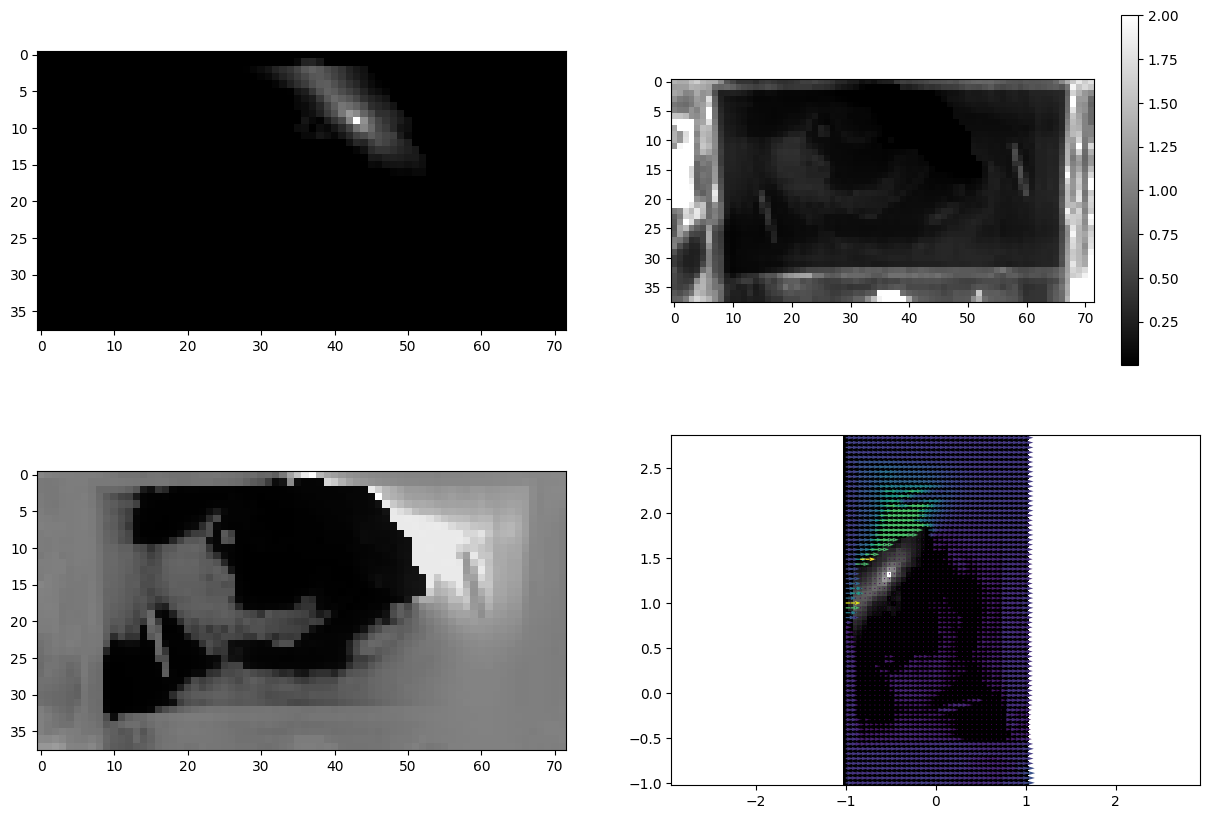

In [ ]:
pred = ff_forwardpass_fiber(Xall, params_fiber)

dI = np.exp(pred[:,0])
df = np.exp(pred[:,1])
a = np.tanh(pred[:,2])
b = np.tanh(pred[:,3])


f1 = a*np.sqrt(1 - b**2 + 1e-6)
f2 = np.sqrt(1 - a**2 + 1e-6)*np.sqrt(1 - b**2 + 1e-6)
f3 = b

plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.imshow(dI.reshape((Nx, Ny)), cmap='gray')

plt.subplot(2,2,2)
plt.imshow(df.reshape((Nx, Ny)), vmax = 2,cmap='gray')
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(f1.reshape((Nx, Ny)), cmap='gray')

# plt.subplot(2,2,4)
# plt.imshow(f2.reshape((Nx, Ny)), cmap='gray')

plt.subplot(2,2,4)
plt.pcolor(X,Y,dI.reshape((Nx, Ny)), cmap='gray') # mapa de difusión dI
plt.quiver(Xall[:,0], Xall[:,1], f1, f2, f3) # flechas con la dirección de cada fibra
plt.axis('equal')

(array([2369.,  286.,   68.,    6.,    4.,    3.,    0.,    0.,    0.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <BarContainer object of 9 artists>)

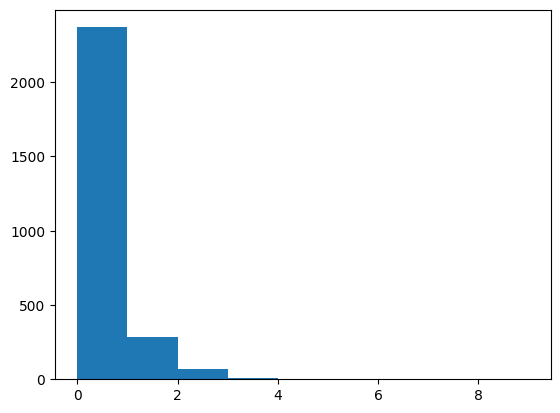

In [ ]:
plt.hist(df, np.arange(0,10)) # Valores de df cercanos a 0, es decir de poca difusión

In [ ]:
# Calculamos D a partir de la red neuronal

pred_I = vmap(ff_forwardpass, in_axes = (0, None))(input, params)

pred_I = pred_I[...,0] + 1j*pred_I[...,1]

ui, vi, wi = dirs[selected_dirs].T # componentes de vectores de dirección de los gradientes de difusión.T
b_matrix = 1500*np.c_[ui**2, vi**2, wi**2, 2*ui*vi, 2*ui*wi, 2*vi*wi] # b vale 1500 y se construye la matriz b con él
b_inv = np.linalg.pinv(b_matrix) # pseudoinversa de b

print(pred_I.shape)

D_vec = vmap(lambda logM0, Is: b_inv @ (np.log(abs(Is)) - logM0), in_axes = (0, 0))(logM0, pred_I.T) # vector D

D_mat = vmap(lambda D: np.array([[D[0], D[3], D[4]],
                                 [D[3], D[1], D[5]],
                                 [D[4], D[5], D[2]]]))(D_vec) # matriz D a partir de los valores de D

eigvals, eigvecs = np.linalg.eigh(D_mat) # calculo de auto vectores y valores.

(12, 2736)


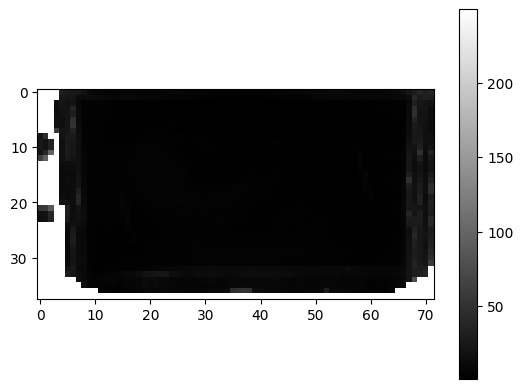

In [ ]:
I_pred = log_forward_model(input_f[0], params_fiber) # resultado del modelo predictivo

plt.imshow(((I_pred - np.abs(pred_I[0]))**2).reshape((Nx, Ny)), cmap='gray') # (resultado - resultado de ff_forwardpass) ^ 2
plt.colorbar()

In [ ]:
eigvals.shape, eigvecs.shape

((2736, 3), (2736, 3, 3))

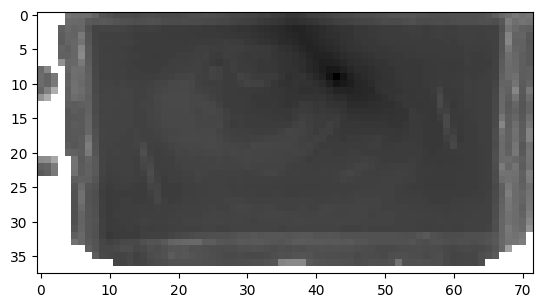

In [ ]:
plt.imshow(eigvals[:,0].reshape((Nx, Ny)), cmap='gray') # valor propio más bajo de cada voxel, de poca difusión
# es decir, el voxel con menos difusión de todos

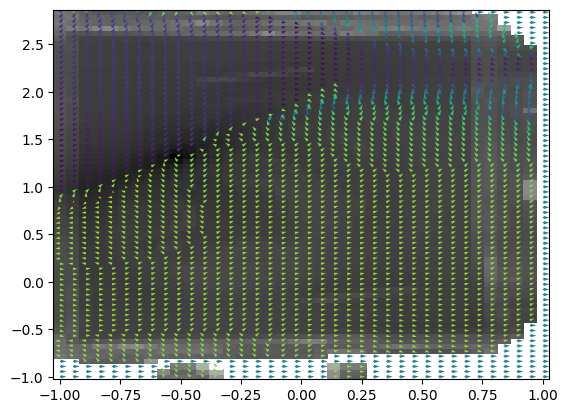

In [ ]:
plt.pcolor(X,Y,eigvals[:,0].reshape((Nx,Ny)), cmap='gray')
plt.quiver(Xall[:,0], Xall[:,1], eigvecs[:,0,0], eigvecs[:,0,1], eigvecs[:,0,2]) # se dibujan las direcciones del valor propio más bajo en cada voxel
# eigvecs[:,0,0] es en x y así eigvecs[:,0,1] en y, Xall[:,0], Xall[:,1] son las coordenadas de cada voxel en 2D

In [ ]:
ui, vi, wi = dirs[selected_dirs].T # componentes de vectores de dirección de los gradientes de difusión.T
b_matrix = 1500*np.c_[ui**2, vi**2, wi**2, 2*ui*vi, 2*ui*wi, 2*vi*wi] # b vale 1500 y se construye la matriz b con él
b_inv = np.linalg.pinv(b_matrix) # pseudoinversa de b

# original = image[:,:,22,0,0].copy()
# print(original.shape)
# print(logM0.shape)

input = []
for i,dir_idx in enumerate(selected_dirs): # son 12 puntos en selected_dirs
    input.append(slice[dir_idx])
input = np.array(input)

print(input.shape)
signal = input.reshape(12, -1)
print(signal.shape)

original = image.reshape(-1, len(selected_dirs))

D_vec = vmap(lambda logM0, Is: b_inv @ (np.log(abs(Is)) - logM0), in_axes = (0, 0))(logM0, signal.T) # vector D

D_mat = vmap(lambda D: np.array([[D[0], D[3], D[4]],
                                 [D[3], D[1], D[5]],
                                 [D[4], D[5], D[2]]]))(D_vec) # matriz D a partir de los valores de D

eigvals, eigvecs = np.linalg.eigh(D_mat) # calculo de auto vectores y valores.

(12, 38, 72)
(12, 2736)


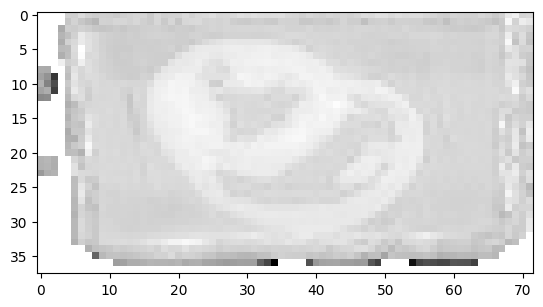

In [ ]:
plt.imshow(eigvals[:,0].reshape((Nx, Ny)), cmap='gray') # valor propio más bajo de cada voxel, de poca difusión
# es decir, el voxel con menos difusión de todos

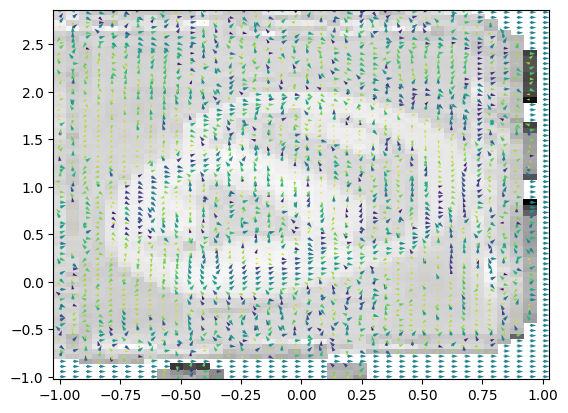

In [ ]:
plt.pcolor(X,Y,eigvals[:,0].reshape((Nx,Ny)), cmap='gray')
plt.quiver(Xall[:,0], Xall[:,1], eigvecs[:,0,0], eigvecs[:,0,1], eigvecs[:,0,2]) # se dibujan las direcciones del valor propio más bajo en cada voxel
# eigvecs[:,0,0] es en x y así eigvecs[:,0,1] en y, Xall[:,0], Xall[:,1] son las coordenadas de cada voxel en 2D

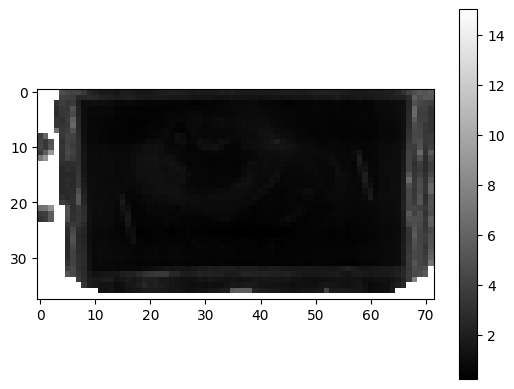

In [ ]:
plt.imshow(((np.abs(I_pred) - np.abs(signal[0]))).reshape((Nx, Ny)), cmap='gray') # (resultado - resultado de ff_forwardpass) ^ 2
plt.colorbar()

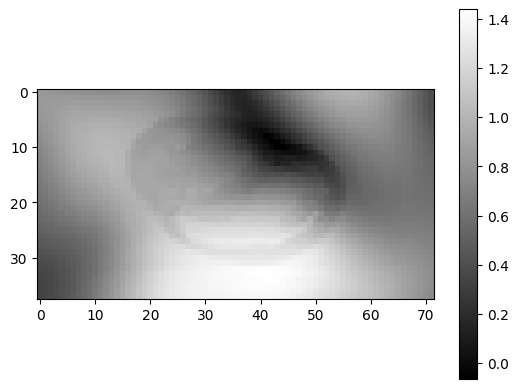

In [ ]:
plt.imshow(((np.abs(pred_I[0]) - np.abs(signal[0]))).reshape((Nx, Ny)), cmap='gray') # (resultado - resultado de ff_forwardpass) ^ 2
plt.colorbar()